In [2]:
# --- IMPORTS ---
import os
import json
import random
import numpy as np
import tensorflow as tf
import keras_cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

# --- CONFIGURATION ---
class Config:
    # Data paths
    DATA_DIR = '/kaggle/input/malaria-bounding-boxes/malaria/images'
    JSON_PATH = '/kaggle/input/malaria-bounding-boxes/malaria/training.json'
    
    # Model and training parameters
    IMG_HEIGHT = 640
    IMG_WIDTH = 640
    VALIDATION_SPLIT = 0.2
    
    # For a 2-GPU setup on Kaggle
    PER_REPLICA_BATCH_SIZE = 16 
    NUM_GPUS = 2
    GLOBAL_BATCH_SIZE = PER_REPLICA_BATCH_SIZE * NUM_GPUS
    
    # Other settings
    AUTOTUNE = tf.data.AUTOTUNE
    SEED = 42

# Instantiate the config
config = Config()

# Set a random seed for reproducibility
random.seed(config.SEED)
np.random.seed(config.SEED)
tf.random.set_seed(config.SEED)

print(f"TensorFlow Version: {tf.__version__}")
print(f"KerasCV Version: {keras_cv.__version__}")
print(f"Global batch size set to: {config.GLOBAL_BATCH_SIZE}")

TensorFlow Version: 2.18.0
KerasCV Version: 0.9.0
Global batch size set to: 32


In [3]:
def parse_data(image_dir, json_path):
    """Parses the JSON file and prepares the data for training."""
    
    with open(json_path, 'r') as f:
        json_data = json.load(f)

    # --- Create a class mapping ---
    all_class_names = set()
    for item in json_data:
        for obj in item['objects']:
            all_class_names.add(obj['category'])
            
    class_to_id = {name: i for i, name in enumerate(sorted(list(all_class_names)))}
    id_to_class = {i: name for name, i in class_to_id.items()}
    
    print(f"Class mapping created: {class_to_id}")

    # --- Extract image paths, boxes, and classes ---
    all_data = []
    for item in json_data:
        image_name = os.path.basename(item['image']['pathname'])
        image_path = os.path.join(image_dir, image_name)

        boxes = []
        class_ids = []
        for obj in item['objects']:
            b_box = obj['bounding_box']
            y_min, x_min = b_box['minimum']['r'], b_box['minimum']['c']
            y_max, x_max = b_box['maximum']['r'], b_box['maximum']['c']
            
            # Skip invalid boxes
            if x_min < x_max and y_min < y_max:
                # Bounding box format is [x_min, y_min, x_max, y_max]
                boxes.append([x_min, y_min, x_max, y_max])
                class_ids.append(class_to_id[obj['category']])
            else:
                print(f"Skipping invalid box in image: {image_name}")
        
        # Only add images that have valid annotations
        if boxes:
            all_data.append({
                'image_path': image_path,
                'boxes': np.array(boxes, dtype=np.float32),
                'classes': np.array(class_ids, dtype=np.int32)
            })

    return all_data, class_to_id, id_to_class

# --- Load and Parse the Data ---
all_data, class_to_id, id_to_class = parse_data(config.DATA_DIR, config.JSON_PATH)
print(f"\nSuccessfully parsed {len(all_data)} images with their annotations.")

Class mapping created: {'difficult': 0, 'gametocyte': 1, 'leukocyte': 2, 'red blood cell': 3, 'ring': 4, 'schizont': 5, 'trophozoite': 6}

Successfully parsed 1208 images with their annotations.


Data split into 966 training samples and 242 validation samples.

Visualizing a random training sample...


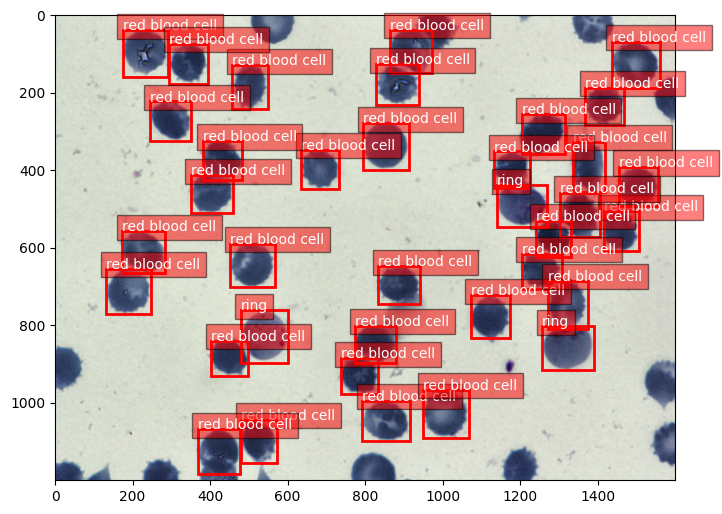

In [4]:
# --- Shuffle and Split the Data ---
random.shuffle(all_data)
split_index = int(len(all_data) * (1 - config.VALIDATION_SPLIT))
train_data = all_data[:split_index]
val_data = all_data[split_index:]

print(f"Data split into {len(train_data)} training samples and {len(val_data)} validation samples.")

# --- Visualize a Sample (Optional but Recommended) ---
def visualize_sample(data_sample, id_to_class_map):
    """Displays an image with its bounding boxes."""
    img = Image.open(data_sample['image_path'])
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img)
    
    for box, class_id in zip(data_sample['boxes'], data_sample['classes']):
        x_min, y_min, x_max, y_max = box
        width, height = x_max - x_min, y_max - y_min
        rect = patches.Rectangle(
            (x_min, y_min), width, height,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        class_name = id_to_class_map[class_id]
        ax.text(x_min, y_min, class_name, color='white', fontsize=10, bbox=dict(facecolor='red', alpha=0.5))
        
    plt.show()

print("\nVisualizing a random training sample...")
visualize_sample(random.choice(train_data), id_to_class)

In [5]:
def load_and_preprocess(image_path, boxes, classes):
    """Loads, decodes, and resizes an image."""
    img_bytes = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img_bytes, channels=3)
    img = tf.image.resize(img, [config.IMG_HEIGHT, config.IMG_WIDTH])
    
    # The model expects labels as a dictionary
    labels = {"boxes": boxes, "classes": classes}
    return img, labels

    # Create a generator
def build_dataset(data, batch_size, is_training=True, repeat_for_validation=False):
    """Builds a tf.data pipeline."""
    
    # Create a generator
    def generator():
        for item in data:
            yield item['image_path'], item['boxes'], item['classes']
            
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.int32)
        )
    )
    
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=config.AUTOTUNE)
    
    if is_training:
        dataset = dataset.shuffle(buffer_size=512)
        dataset = dataset.repeat()
    elif repeat_for_validation:  # New conditional for validation repetition
        dataset = dataset.repeat()
        
    # Padded batching (retained from your fix)
    dataset = dataset.padded_batch(
        batch_size,
        padding_values=(0.0, {"boxes": -1.0, "classes": -1}),
        drop_remainder=True
    )
    
    dataset = dataset.prefetch(buffer_size=config.AUTOTUNE)
    
    return dataset

# Re-create datasets with the update
train_ds = build_dataset(train_data, config.GLOBAL_BATCH_SIZE, is_training=True)
val_ds = build_dataset(val_data, config.GLOBAL_BATCH_SIZE, is_training=False, repeat_for_validation=True)  # Enable repetition

# Compute validation steps dynamically
validation_steps = max(1, len(val_data) // config.GLOBAL_BATCH_SIZE)

print("\nDatasets updated with validation repetition. Ready for training! ✅")

I0000 00:00:1764198111.331127      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



Datasets updated with validation repetition. Ready for training! ✅


In [ ]:
# --- Set up Multi-GPU Strategy ---
try:
    strategy = tf.distribute.MirroredStrategy()
    print(f'✅ Strategy successfully created. Running on {strategy.num_replicas_in_sync} devices.')
except:
    print('❌ Could not create MirroredStrategy. Falling back to default strategy.')
    strategy = tf.distribute.get_strategy()

# --- Build and Compile Model within Strategy Scope ---
with strategy.scope():
    # Define the model
    backbone = keras_cv.models.YOLOV8Backbone.from_preset(
        "yolo_v8_m_backbone_coco" # Using pretrained weights
    )
    model = keras_cv.models.YOLOV8Detector(
        num_classes=len(class_to_id),
        bounding_box_format="xyxy",
        backbone=backbone,
        fpn_depth=2, # You can adjust depth for model complexity
    )
    
    # Freeze the backbone for initial training
    model.backbone.trainable = False

    # Define the optimizer
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=1e-4,
        global_clipnorm=10.0
    )

    # Compile the model
    model.compile(
        optimizer=optimizer,
        classification_loss='binary_crossentropy',
        box_loss='ciou'
    )
    
print("\nModel built and compiled successfully within the strategy scope.")
model.summary()

In [ ]:
# --- Set up Callbacks ---
tensorboard_callback = TensorBoard(log_dir="logs", histogram_freq=1)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# --- Calculate Steps ---
steps_per_epoch = len(train_data) // config.GLOBAL_BATCH_SIZE
validation_steps = len(val_data) // config.GLOBAL_BATCH_SIZE

if steps_per_epoch == 0:
    steps_per_epoch = 1
# Compute validation steps to match dataset size precisely
validation_steps = max(1, len(val_data) // config.GLOBAL_BATCH_SIZE)


# --- Train the Model ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30, # Start with a reasonable number of epochs
    callbacks=[tensorboard_callback, early_stopping_callback],
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)



In [ ]:
# Save weights with the required extension
model.save_weights('/kaggle/working/model_weights_epoch30.weights.h5')

In [ ]:
# --- Stage B: Unfreeze Top Layers and Continue Training ---
with strategy.scope():
    # Rebuild the model architecture (must match original)
    backbone = keras_cv.models.YOLOV8Backbone.from_preset(
        "yolo_v8_m_backbone_coco"  # Using pretrained weights
    )
    model = keras_cv.models.YOLOV8Detector(
        num_classes=len(class_to_id),
        bounding_box_format="xyxy",
        backbone=backbone,
        fpn_depth=2,  # You can adjust depth for model complexity
    )
    
    # Load the weights from the end of Stage A (epoch 30)
    weights_path = '/kaggle/working/model_weights_epoch30.weights.h5'
    model.load_weights(weights_path)
    print("✅ Loaded weights from Stage A (epoch 30).")
    
    # Unfreeze the top few layers of the backbone (e.g., last 2 dark blocks for fine-tuning)
    # YOLOV8 backbone layers: stem, dark2, dark3, dark4, dark5
    # Unfreeze dark4 and dark5 (top layers) for specialized adjustments
    for layer in model.backbone.layers:
        if 'dark4' in layer.name or 'dark5' in layer.name:
            layer.trainable = True
        else:
            layer.trainable = False  # Keep lower layers frozen
    
    print("✅ Unfroze top layers (dark4 and dark5) of the backbone.")
    
    # Define a very low learning rate for fine-tuning
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=1e-5,  # Reduced from 1e-4 for fine-tuning
        global_clipnorm=10.0
    )
    
    # Recompile with the updated optimizer
    model.compile(
        optimizer=optimizer,
        classification_loss='binary_crossentropy',
        box_loss='ciou'
    )
    
print("\nModel updated for Stage B within the strategy scope.")
model.summary()

# --- Set up Callbacks (Reuse and Adjust as Needed) ---
tensorboard_callback = TensorBoard(log_dir="logs_stage_b", histogram_freq=1)  # Separate log dir for this stage

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# --- Calculate Steps ---
steps_per_epoch = len(train_data) // config.GLOBAL_BATCH_SIZE
if steps_per_epoch == 0:
    steps_per_epoch = 1

# --- Train for Additional 20 Epochs (Stage B) ---
history_stage_b = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,  # Total epochs (will run 31-50)
    initial_epoch=30,  # Resume after epoch 30
    callbacks=[tensorboard_callback, early_stopping_callback],
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

# --- Save Final Weights After Stage B ---
model.save_weights('/kaggle/working/model_weights_epoch50.weights.h5')
print("✅ Stage B training completed. Final weights saved as model_weights_epoch50.weights.h5")

In [9]:
import tensorflow as tf
import keras_cv
import gc
import os

# --- 1. RESET MEMORY ---
tf.keras.backend.clear_session()
gc.collect()

# --- 2. DEFINE DATA PIPELINE (Streaming Mode) ---
def load_and_preprocess_fast(image_path, boxes, classes):
    img = tf.io.decode_jpeg(tf.io.read_file(image_path), channels=3)
    img = tf.image.resize(img, [512, 512])
    img = tf.cast(img, tf.float32) / 255.0
    return img, {"boxes": boxes, "classes": classes}

def build_fast_dataset(data, batch_size, is_training=True):
    dataset = tf.data.Dataset.from_generator(
        lambda: ((item['image_path'], item['boxes'], item['classes']) for item in data),
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.int32)
        )
    )
    
    # Parallel loading
    dataset = dataset.map(load_and_preprocess_fast, num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        dataset = dataset.shuffle(256)
    
    dataset = dataset.padded_batch(
        batch_size, 
        padding_values=(0.0, {"boxes": -1.0, "classes": -1}), 
        drop_remainder=True 
    )
    
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# --- 3. BUILD DATASETS ---
print("🚀 Building Datasets...")
BATCH_SIZE = 16 
train_ds = build_fast_dataset(train_data, BATCH_SIZE, is_training=True)
val_ds = build_fast_dataset(val_data, BATCH_SIZE, is_training=False)

# --- 4. BUILD MODEL (The Missing Step) ---
print("🏗️ Building Student Model (YOLOv8-Small)...")
student_backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_s_backbone_coco")
student_model = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_to_id),
    bounding_box_format="xyxy",
    backbone=student_backbone,
    fpn_depth=2, 
)

# --- 5. COMPILE & TRAIN ---
student_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    classification_loss='binary_crossentropy',
    box_loss='ciou'
)

print("⚡ Starting Training...")
history = student_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

# --- 6. SAVE ---
student_model.save_weights('/kaggle/working/malaria_mobile_streaming.weights.h5')
print("✅ Done. Model saved.")

🚀 Building Datasets...
🏗️ Building Student Model (YOLOv8-Small)...
⚡ Starting Training...
Epoch 1/5
     60/Unknown 1048s 16s/step - box_loss: 2.0117 - class_loss: 30.2479 - loss: 32.2596

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


60/60 ━━━━━━━━━━━━━━━━━━━━ 1110s 18s/step - box_loss: 2.0107 - class_loss: 30.0887 - loss: 32.0994 - val_box_loss: 2.0902 - val_class_loss: 12.8198 - val_loss: 14.9100
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 406s 7s/step - box_loss: 1.8287 - class_loss: 6.7846 - loss: 8.6134 - val_box_loss: 2.0402 - val_class_loss: 4.1817 - val_loss: 6.2218
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - box_loss: 1.8271 - class_loss: 2.3742 - loss: 4.2012 - val_box_loss: 1.8201 - val_class_loss: 1.5905 - val_loss: 3.4106
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - box_loss: 1.7920 - class_loss: 1.3019 - loss: 3.0939 - val_box_loss: 1.9108 - val_class_loss: 1.0044 - val_loss: 2.9153
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - box_loss: 1.7637 - class_loss: 0.8967 - loss: 2.6604 - val_box_loss: 2.0451 - val_class_loss: 1.3143 - val_loss: 3.3594
✅ Done. Model saved.


In [10]:
import json
import os
import numpy as np
import tensorflow as tf
import keras_cv

# --- CONFIGURATION ---
IMG_DIR = '/kaggle/input/malaria-bounding-boxes/malaria/images'
TEST_JSON = '/kaggle/input/malaria-bounding-boxes/malaria/test.json'
IMG_SIZE = 512

# --- 1. PARSE TEST DATA (Using Existing Class ID) ---
def parse_test_json(json_path, image_dir, existing_class_map):
    with open(json_path, 'r') as f:
        data = json.load(f)
        
    cleaned_data = []
    print(f"📂 Parsing {json_path}...")
    
    for item in data:
        image_name = os.path.basename(item['image']['pathname'])
        image_path = os.path.join(image_dir, image_name)
        
        boxes = []
        classes = []
        
        for obj in item['objects']:
            # Validate box coordinates
            ymin, xmin = obj['bounding_box']['minimum']['r'], obj['bounding_box']['minimum']['c']
            ymax, xmax = obj['bounding_box']['maximum']['r'], obj['bounding_box']['maximum']['c']
            
            if xmax > xmin and ymax > ymin:
                boxes.append([xmin, ymin, xmax, ymax])
                # CRITICAL: Use the training class_to_id, do not invent new ones
                classes.append(existing_class_map[obj['category']])
                
        if boxes:
            cleaned_data.append({
                'image_path': image_path,
                'boxes': np.array(boxes, dtype=np.float32),
                'classes': np.array(classes, dtype=np.int32)
            })
            
    print(f"✅ Loaded {len(cleaned_data)} test images.")
    return cleaned_data

# Run Parser (Uses the global class_to_id from your training step)
test_data_raw = parse_test_json(TEST_JSON, IMG_DIR, class_to_id)

# --- 2. BUILD TEST DATASET (No Shuffle) ---
def load_test_image(image_path, boxes, classes):
    img = tf.io.decode_jpeg(tf.io.read_file(image_path), channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0 # Normalize
    return img, {"boxes": boxes, "classes": classes}

test_ds = tf.data.Dataset.from_generator(
    lambda: ((d['image_path'], d['boxes'], d['classes']) for d in test_data_raw),
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
)
test_ds = test_ds.map(load_test_image, num_parallel_calls=tf.data.AUTOTUNE)
# Batch size 1 for accurate latency testing
test_ds = test_ds.padded_batch(1, padding_values=(0.0, {"boxes": -1.0, "classes": -1}))
print("✅ Test Dataset Ready.")

📂 Parsing /kaggle/input/malaria-bounding-boxes/malaria/test.json...
✅ Loaded 120 test images.
✅ Test Dataset Ready.


In [11]:
import time

# --- 3. EVALUATION FUNCTION ---
def evaluate_model_on_test(model, dataset, name):
    print(f"\n📊 EVALUATING {name} ON TEST SET...")
    
    # Metrics
    coco_metrics = keras_cv.metrics.BoxCOCOMetrics(
        bounding_box_format="xyxy", 
        evaluate_freq=1e9
    )
    
    # Accuracy Loop
    print(f"... Calculating mAP & Recall for {name}...")
    start_eval = time.time()
    for batch in dataset:
        images, labels = batch
        preds = model.predict(images, verbose=0)
        coco_metrics.update_state(labels, preds)
    print(f"... Evaluation took {time.time() - start_eval:.1f}s")
        
    metrics = coco_metrics.result()
    
    # Speed Loop (Latency)
    print("... Measuring Latency...")
    dummy = tf.ones((1, IMG_SIZE, IMG_SIZE, 3))
    # Warmup
    for _ in range(5): model(dummy, training=False)
    # Test
    t0 = time.time()
    for _ in range(100): model(dummy, training=False)
    t1 = time.time()
    
    latency = ((t1 - t0) / 100) * 1000
    fps = 1000 / latency
    params = model.count_params() / 1e6

    # Print Report
    print("-" * 40)
    print(f"🏆 FINAL RESULTS: {name}")
    print(f"   mAP @ 50:    {metrics['MaP']:.4f}")
    print(f"   Recall:      {metrics['MAR_100']:.4f}")
    print(f"   Latency:     {latency:.2f} ms")
    print(f"   FPS:         {fps:.2f}")
    print(f"   Size:        {params:.2f} M Params")
    print("-" * 40)
    return metrics, latency

# --- 4. LOAD & RUN ---
# Load Teacher (Medium)
print("Loading Teacher...")
teacher = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_to_id), bounding_box_format="xyxy",
    backbone=keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_m_backbone_coco"),
    fpn_depth=2
)
# Ensure you point to the correct file you saved earlier for the teacher
# If you didn't save the teacher explicitly, you might rely on the variable 'teacher_model' if it's in memory.
# Assuming you have the file from Stage B:
teacher.load_weights("/kaggle/working/model_weights_epoch50.weights.h5")

# Load Student (Small) - Using the 'Streaming' weights we just saved
print("Loading Student...")
student = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_to_id), bounding_box_format="xyxy",
    backbone=keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_s_backbone_coco"),
    fpn_depth=2
)
student.load_weights("/kaggle/working/malaria_mobile_streaming.weights.h5")

# Execute
evaluate_model_on_test(teacher, test_ds, "Teacher (Medium)")
evaluate_model_on_test(student, test_ds, "Student (Small)")

Loading Teacher...


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/kaggle/working/model_weights_epoch50.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)